In [14]:
import csv
import pandas as pd
import geopandas as gpd
from shapely.geometry import Point, box
import matplotlib.pyplot as plt
import numpy as np
import csv

In [43]:
# --- Step 1: Bounding Box Coordinates ---
nelat = 37.833063
nelng = -122.358327
swlat = 37.708244
swlng = -122.518243

rows = []
with open('observations-580728.csv', 'r') as file:
    csvreader = csv.DictReader(file)
    for row in csvreader:
        if row['latitude'] and row['longitude']:
            rows.append({
                'latitude': float(row['latitude']),
                'longitude': float(row['longitude']),
                'species_name': row['scientific_name'],
                'common_name': row['common_name'],
            })

df = pd.DataFrame(rows)

# --- Step 3: Convert to GeoDataFrame ---
geometry = [Point(xy) for xy in zip(df['longitude'], df['latitude'])]
gdf_obs = gpd.GeoDataFrame(df, geometry=geometry, crs='EPSG:4326')

import h3
import geopandas as gpd
from shapely.geometry import Polygon

# --- Step 4: Create Hex Grid over the Bounding Box ---

def hexagons_from_points(gdf_points, resolution=10):
    """
    Generate hexagons from point data using H3 (v4+).
    """
    # Convert lat/lon to H3 cell ID
    gdf_points['h3_id'] = gdf_points.geometry.apply(
        lambda pt: h3.latlng_to_cell(pt.y, pt.x, resolution)
    )

    # Unique hexagons
    unique_hexes = gdf_points['h3_id'].unique()

    # Create polygons from hex boundaries
    """hex_polys = [
        Polygon(h3.cell_to_boundary(h))
        for h in unique_hexes
    ]"""
    hex_polys = []
    for h in unique_hexes:
        boundary = h3.cell_to_boundary(h)
        # h3.cell_to_boundary returns [(lat, lon), ...], we need (lon, lat)
        coords = [(lng, lat) for lat, lng in boundary]
        poly = Polygon(coords)
        hex_polys.append(poly)

    hex_gdf = gpd.GeoDataFrame({'h3_id': unique_hexes, 'geometry': hex_polys}, crs='EPSG:4326')

    return gdf_points, hex_gdf



bbox = (swlng, swlat, nelng, nelat)

gdf_obs, grid_gdf = hexagons_from_points(gdf_obs, resolution=9)

# Group by H3 cell ID
obs_count = gdf_obs.groupby('h3_id').size().reset_index(name='obs_count')
species_richness = gdf_obs.groupby('h3_id')['species_name'].nunique().reset_index(name='species_richness')

# Merge into grid
grid_gdf = grid_gdf.merge(obs_count, on='h3_id', how='left')
grid_gdf = grid_gdf.merge(species_richness, on='h3_id', how='left')

# Fill missing with 0
grid_gdf['obs_count'] = grid_gdf['obs_count'].fillna(0)
grid_gdf['species_richness'] = grid_gdf['species_richness'].fillna(0)
grid_gdf['log_richness'] = np.log1p(grid_gdf['species_richness'])


# --- Step 5: Spatial Join Observations to Grid ---
gdf_obs_in_grid = gpd.sjoin(gdf_obs, grid_gdf, how='left', predicate='within')

In [44]:
from branca.colormap import LinearColormap

grid_gdf = grid_gdf[grid_gdf['species_richness'] > 1]
grid_gdf = grid_gdf[grid_gdf.geometry.is_valid]

# Step 2: Create a colormap from min to max of log values
log_min = grid_gdf['log_richness'].min()
log_max = grid_gdf['log_richness'].max()

colormap = LinearColormap(
    colors=["#ffffff", '#74c476', '#00441b'],  # Light to dark green
    vmin=log_min,
    vmax=log_max,
    caption='Species Richness (log scale)'
)
# Step 3: Style function using log-scaled value
def style_function(feature):
    log_val = feature['properties'].get('log_richness', 0)
    
    # Make cells with 0 richness fully transparent
    if log_val == 0:
        return {
            'fillOpacity': 0,
            'weight': 0,
            'color': 'transparent'
        }
    
    # Otherwise use color from colormap
    return {
        'fillColor': colormap(log_val),
        'color': 'transparent',
        'weight': 0,
        'fillOpacity': 0.6
    }

In [45]:
import folium
from folium import Choropleth

# Step 1: Convert grid GeoDataFrame to GeoJSON
geojson_data = grid_gdf.to_crs(epsg=4326).to_json()

# Step 2: Create a base map centered on SF
sf_center = [(nelat + swlat) / 2, (nelng + swlng) / 2]
m = folium.Map(location=sf_center, zoom_start=12, tiles='OpenStreetMap')

# Optional: Add tooltip with grid ID and count
folium.GeoJson(
    data=geojson_data,
    name='Grid',
    style_function=style_function,
    tooltip=folium.GeoJsonTooltip(
        fields=['h3_id', 'species_richness'],
        aliases=['Grid ID:', '# of native plant species:'],
        localize=True
    )
).add_to(m)

# Display (in notebook) or save
m.save("species_grid_map.html")
m

In [ ]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

# --- Step 1: Filter observations in species-rich grids ---
obs_in_rich_grids = gdf_obs_in_grid[gdf_obs_in_grid['grid_id'].isin(
    grid_gdf['grid_id']
)]

# --- Step 2: Create species-by-grid matrix (presence/absence) ---
species_grid_matrix = pd.crosstab(
    obs_in_rich_grids['common_name'],
    obs_in_rich_grids['grid_id']
)

# Optional: drop rare species (only in 3 grid)
species_grid_matrix = species_grid_matrix[species_grid_matrix.sum(axis=1) > 50]


: 

: 

: 

: 

In [ ]:
import plotly.express as px
import pandas as pd
import umap.umap_ as umap

# --- UMAP projection ---
reducer = umap.UMAP(n_neighbors=10, min_dist=0.3, metric='jaccard', random_state=42)
embedding = reducer.fit_transform(species_grid_matrix)

# --- Prepare dataframe ---
umap_df = pd.DataFrame(embedding, columns=['x', 'y'])
umap_df['species_name'] = species_grid_matrix.index


/Users/mertbozfakioglu/Documents/nature-in-sf/sf_plant_community_map/.venv/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/Users/mertbozfakioglu/Documents/nature-in-sf/sf_plant_community_map/.venv/lib/python3.13/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/mertbozfakioglu/Documents/nature-in-sf/sf_plant_community_map/.venv/lib/python3.13/site-packages/umap/umap_.py:1887: UserWarning: gradient function is not yet implemented for jaccard distance metric; inverse_transform will be unavailable
  warn(
/Users/mertbozfakioglu/Documents/nature-in-sf/sf_plant_community_map/.venv/lib/python3.13/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting 

: 

: 

: 

: 

In [ ]:
from sklearn.cluster import KMeans

n_clusters = 7  # choose how many clusters you want
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
umap_df['cluster'] = kmeans.fit_predict(umap_df[['x', 'y']])
umap_df['cluster'] = umap_df['cluster'].astype(str)

import plotly.express as px

fig = px.scatter(
    umap_df,
    x='x',
    y='y',
    color='cluster',
    symbol='cluster',
    text='species_name',
    hover_name='species_name',
    title='UMAP projection of species with clusters',
    width=900,
    height=700,
    color_continuous_scale=px.colors.qualitative.Safe
)

fig.update_traces(textposition='top center', marker=dict(size=6, opacity=0.7))
fig.update_layout(
    hovermode='closest',
    margin=dict(l=20, r=20, t=40, b=20),
    plot_bgcolor='white'
)

fig.show()
fig.write_html("umap_species_clusters.html")


: 

: 

: 

: 

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Create a pivot table counting observations of each species in each grid
species_grid_matrix = (
    gdf_obs_in_grid
    .groupby(['grid_id', 'common_name'])
    .size()
    .unstack(fill_value=0)  # rows=grid_id, columns=species, values=count
)

species_counts = species_grid_matrix.sum(axis=0)

# Step 2: Filter species with at least 50 observations
filtered_species = species_counts[species_counts >= 400].index
filtered_matrix = species_grid_matrix[filtered_species]

# 1. Compute Pearson correlation matrix between species (columns)
corr_matrix = filtered_matrix.corr(method='pearson')


: 

: 

: 

: 

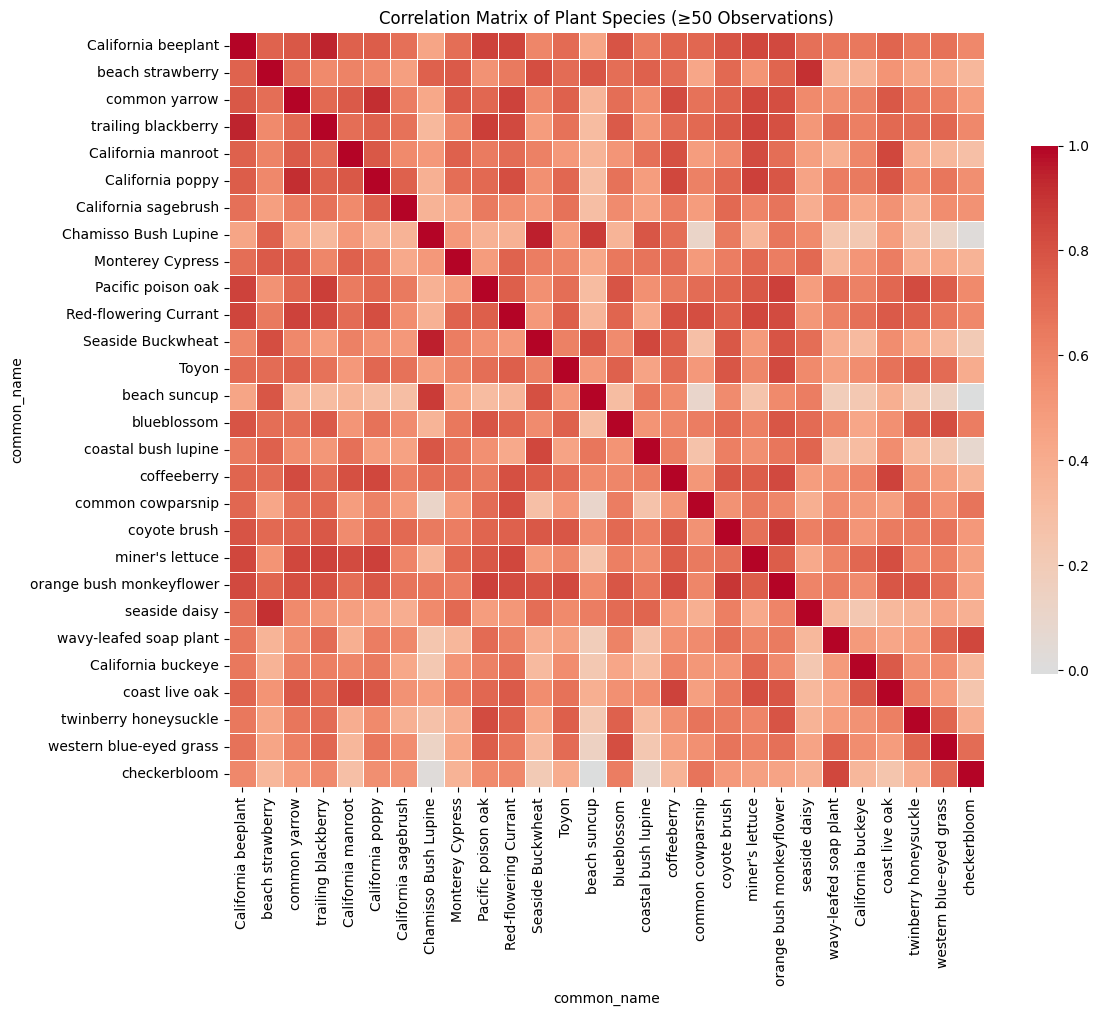

: 

: 

: 

: 

In [ ]:
# Step 4: Plot heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(
    corr_matrix,
    cmap='coolwarm',
    center=0,
    square=True,
    linewidths=0.5,
    cbar_kws={"shrink": 0.7},
    xticklabels=True,
    yticklabels=True
)
plt.title("Correlation Matrix of Plant Species (≥50 Observations)")
plt.tight_layout()
plt.show()
